**PCA and SVM for the entire dataset**

In [1]:
####### Import the necessary libraries #######
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import glob

In [2]:
# train_images = []
# train_labels = []
test_images = []
test_labels = []

# images = []
# labels = []
dim = 100

In [3]:
def image_to_feature_vector(image, size=(dim, dim)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

In [4]:
####### Define the loading function for all the dataset #######
def load_all_images(pathName, dataset):

    images = []
    labels = []
    i = 0

    for dirName, subdirList, fileList in os.walk(pathName):
        for fileName in fileList:

            base, extension = os.path.splitext(fileName)

            if extension == '.jpg' or extension == '.JPG' or extension == '.png' or extension == '.PNG':

                imagePath = f"{dirName}/{fileName}"
                image = cv2.imread(imagePath)
                label = os.path.basename(dirName)
                
                # Normalize and flatten the data
                pixels = image_to_feature_vector(image)/255

                images.append(pixels)
                labels.append(label)

                if i > 0 and i % 10000 == 0:
                    if dataset == 'training':
                        print(f"[INFO] training set processed {i}/67692 images")
                    else:
                        print(f"[INFO] test set processed {i}/22688 images")

                i += 1

    return images, labels

In [5]:
####### Define the loading function for specific folders #######
def load_some_images(pathName, fruitList):

    images = []
    labels = []

    for i, fruit in enumerate(fruitList):
        folder = pathName + fruit
        
        for filename in os.listdir(folder):
            
            image = cv2.imread(os.path.join(folder,filename))
            pixels = image_to_feature_vector(image)/255
        
            images.append(pixels)
            labels.append(fruit)

    return images, labels

In [6]:
####### Set the path for the dataset #######
# train_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
test_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/'

In [7]:
####### Load the dataset #######
# train_images, train_labels = load_all_images(train_path, 'training')
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)

test_images, test_labels = load_all_images(test_path, 'test')
test_images = np.array(test_images)
test_labels = np.array(test_labels)

[INFO] test set processed 10000/22688 images
[INFO] test set processed 20000/22688 images


In [8]:
####### Verify the dimensions of the images and labels #######
print(test_images.shape)
print(test_labels.shape)
# print(test_images.shape)
# print(test_labels.shape)

(22688, 30000)
(22688,)


In [9]:
####### Split the data #######
X_train, X_test, y_train, y_test = train_test_split(test_images, test_labels, test_size = 0.2, random_state = 0)

In [10]:
####### Apply PCA on both the training and test set #######
pca = PCA(n_components=5)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

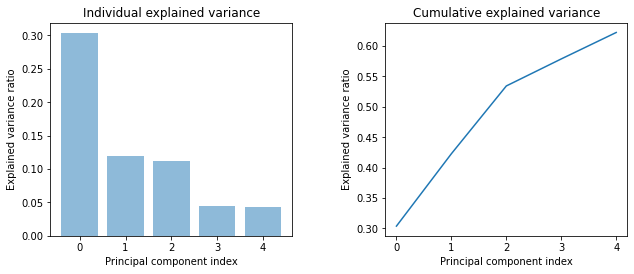

In [11]:
####### Plot the explained variance #######
exp_var_pca = pca.explained_variance_ratio_
cumulative_sum = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Individual explained variance')

plt.subplot(1,2,2)
plt.plot(range(0,len(cumulative_sum)), cumulative_sum)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Cumulative explained variance')
plt.tight_layout(pad=5.0)
plt.show()


In [12]:
####### Set the parameters for SVM #######
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20,30],
            'kernel': ['rbf','linear']
        }  
    } 
}

In [13]:
####### Apply SVM for all the parameters using GridSearch with PCA #######
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], 
                        cv=2, return_train_score=True, verbose=3)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END C=1, kernel=rbf;, score=(train=1.000, test=0.916) total time=  32.8s
[CV 2/2] END C=1, kernel=rbf;, score=(train=1.000, test=0.917) total time=  32.9s
[CV 1/2] END C=1, kernel=linear;, score=(train=0.920, test=0.900) total time=  10.9s
[CV 2/2] END C=1, kernel=linear;, score=(train=0.926, test=0.913) total time=  10.6s
[CV 1/2] END C=10, kernel=rbf;, score=(train=1.000, test=0.926) total time=  32.4s
[CV 2/2] END C=10, kernel=rbf;, score=(train=1.000, test=0.925) total time=  31.9s
[CV 1/2] END C=10, kernel=linear;, score=(train=0.925, test=0.903) total time=  14.3s
[CV 2/2] END C=10, kernel=linear;, score=(train=0.930, test=0.913) total time=  14.1s
[CV 1/2] END C=20, kernel=rbf;, score=(train=1.000, test=0.926) total time=  36.9s
[CV 2/2] END C=20, kernel=rbf;, score=(train=1.000, test=0.925) total time=  36.9s
[CV 1/2] END C=20, kernel=linear;, score=(train=0.926, test=0.902) total time=  20.1s
[CV 2/2] END C=2

In [14]:
####### Print the best scores #######
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
print(df_score)

  model  best_score                 best_params
0   svm    0.925234  {'C': 10, 'kernel': 'rbf'}


 **PCA and SVM for specific classes**

In [15]:
####### Select some fruits to create a confusion matrix #######
fruitList = ['Blueberry', 'Eggplant', 'Mango', 'Potato Red', 'Strawberry', 'Tomato 1']
selected_fruits, selected_labels = load_some_images(test_path, fruitList)

selected_fruits = np.array(selected_fruits)
selected_labels = np.array(selected_labels)

print(selected_fruits.shape)
print(selected_labels.shape)

(1036, 30000)
(1036,)


In [16]:
####### Split the data #######
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(selected_fruits, selected_labels, test_size = 0.2, random_state = 0)

In [17]:
####### Apply PCA on both the training and test set #######
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

In [18]:
####### Apply SVM without PCA #######
svm = SVC(gamma='auto', kernel='rbf', probability=True)
svm.fit(X_train_selected, y_train_selected) 
y_pred = svm.predict(X_test_selected)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test_selected) * 100
print("Accuracy: {0:.2f}%".format(precision))

Accuracy: 99.52%


In [19]:
####### Apply SVM with PCA #######
svm = SVC(gamma='auto', kernel='rbf', probability=True)
svm.fit(X_train_pca, y_train_selected) 
y_pred = svm.predict(X_test_pca)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test_selected) * 100
print("Accuracy: {0:.2f}%".format(precision))

Accuracy: 100.00%


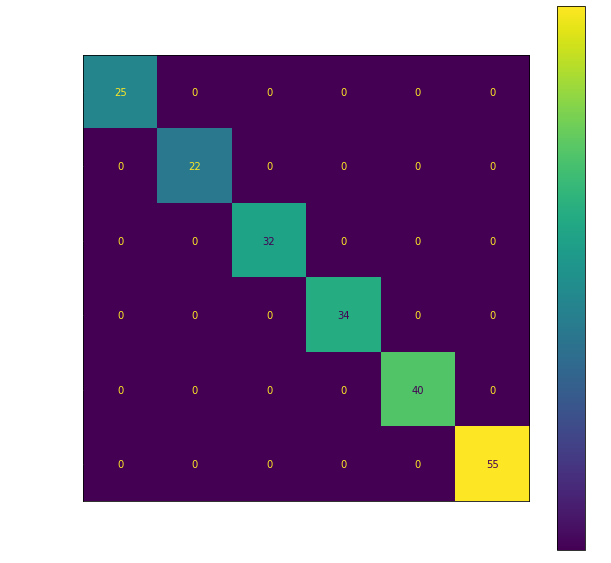

In [31]:
####### Plot the confusion matrix #######

from sklearn.metrics import ConfusionMatrixDisplay
# cm = confusion_matrix(y_test_selected, y_pred, labels=svm.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test_selected, y_pred, ax=ax)

plt.title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()